## Evaluating the  Models 

### Primary Goal: Evaluate the ML and BL models

In this notebook, I'll provide a brief tutorial on how to evaluate the final machine learning (ML) and baseline (BL) models. 

In [1]:
# Import packages 
import pandas as pd
import numpy as np
from os.path import join
import joblib

# Plotting code imports 
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_theme()

# We add the github package to our system path so we can import python scripts for that repo. 
import sys
sys.path.append('/home/monte.flora/python_packages/2to6_hr_severe_wx/')
from main.io import load_ml_data, load_bl_data

from master.ml_workflow.ml_workflow.calibrated_pipeline_hyperopt_cv import CalibratedPipelineHyperOptCV

from os.path import join
from ml_workflow.ml_workflow.ml_methods import norm_aupdc, brier_skill_score 
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve
from sklearn.metrics import precision_recall_curve

In [2]:
# Configuration variables (You'll need to change based on where you store your data)
base_path = '/work/mflora/ML_2TO6HR/data'

In [3]:
def scorer(predictions, y, known_skew, n_boot=30):
    """
    Computes bootstrap-avg for multiple verification scores. 
    """
    naupdc = []
    bss = [] 
    auc = []
    for n in range(n_boot):
        inds = np.random.choice(len(X), size=int(len(X)*0.5))
        pred_i = predictions[inds]
        y_i = y[inds]
        naupdc.append(norm_aupdc(y_i, pred_i, known_skew=known_skew))
        bss.append(brier_skill_score(y_i, pred_i))
        auc.append(roc_auc_score(y_i, pred_i))
    
    #print( f'NAUPDC: {np.mean(naupdc):.03f} | BSS : {np.mean(bss):.03f} | AUC : {np.mean(auc):.03f}')
    return np.mean(naupdc), np.mean(bss), np.mean(auc)

<div class="alert alert-block alert-danger"> <b>CAUTION</b> We are evaluating the models, so make sure mode = 'test' in load_ml_data or load_bl_data </div>

In [4]:
target_col='hail_severe__36km'
mode='test'

X, y, metadata = load_ml_data(base_path=base_path, 
                            mode=mode, 
                            target_col=target_col)


bl_df, _, _ = load_bl_data(base_path=base_path, 
                             mode=mode, 
                             target_col=target_col, 
                            )

X_bl = bl_df['hailcast__nmep_>1_0_45km']

In [5]:
_, y_train, _ = load_ml_data(base_path=base_path, 
                            mode='train', 
                            target_col=target_col)
known_skew = np.mean(y_train)

In [6]:
bl_model = joblib.load('hail_baseline_model.joblib')
ml_data = joblib.load('hail_model.joblib')

ml_model = ml_data['model']
features = ml_data['features']

X = X[features]

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
ml_pred = ml_model.predict_proba(X)[:,1]
bl_pred = bl_model.predict(X_bl)

#scores_ml = scorer(ml_model, X, y, known_skew, n_boot=30)
#scores_bl = scorer(bl_model, X_bl, y, known_skew, n_boot=30)

def plot_verification(ml_pred, bl_pred, scores_ml=None, scores_bl=None):
    """
    A simple plotting script for a reliability and performance diagram. 
    """
    fig, axes = plt.subplots(ncols=2, dpi=300, sharey=True, figsize=(8,4))
    
    c=0
    for label, pred, color in zip(['ML', 'BL'], [ml_pred, bl_pred],  ['r', 'b']): 
        for i, ax in enumerate(axes.flat):
            if i == 0:
                x1, y1 = calibration_curve(y, pred, n_bins=10)
            else:
                x1, y1, _ = precision_recall_curve(y, pred)
    
            ax.set_xlim([0,1])
            ax.set_ylim([0,1])
            if i == 0:
                ax.plot([0,1], [0,1], ls='dashed', color='k', alpha=0.7)
                ax.set_xlabel('Mean Forecast Probability')
                ax.set_ylabel('Conditional Event Frequency')
            else:
                xx = np.linspace(0.001,1,100)
                yy = xx
                xx,yy = np.meshgrid(xx,xx)
                csi = 1 / (1/xx + 1/yy -1)
                cf = ax.contourf(xx,yy,csi, cmap='Blues', alpha=0.3, levels=np.arange(0,1.1,0.1))
                ax.set_xlabel('Success Ratio (SR; 1-FAR)')
                ax.set_ylabel('Probability of Detection (POD)')
                biasLines = ax.contour(
                    xx,
                    yy,
                    yy/xx,
                    colors="k",
                    levels=[0.5, 1.0, 1.5, 2.0, 4.0],
                    linestyles="dashed",
                    linewidths=0.5,
                    alpha=0.9
                    )
                ax.clabel(biasLines, levels=[0.5, 1.0, 1.5, 2.0, 4.0], fontsize=6, inline=True, fmt="%1.1f")
                if c == 0:
                    divider = make_axes_locatable(ax)
                    cax = divider.append_axes('right', size='5%', pad=0.05)
                    fig.colorbar(cf, cax=cax, label='Critical Success Index (CSI)')
                    c+=1
        
            ax.plot(x1,y1,label=label, color=color)

            ax.legend()

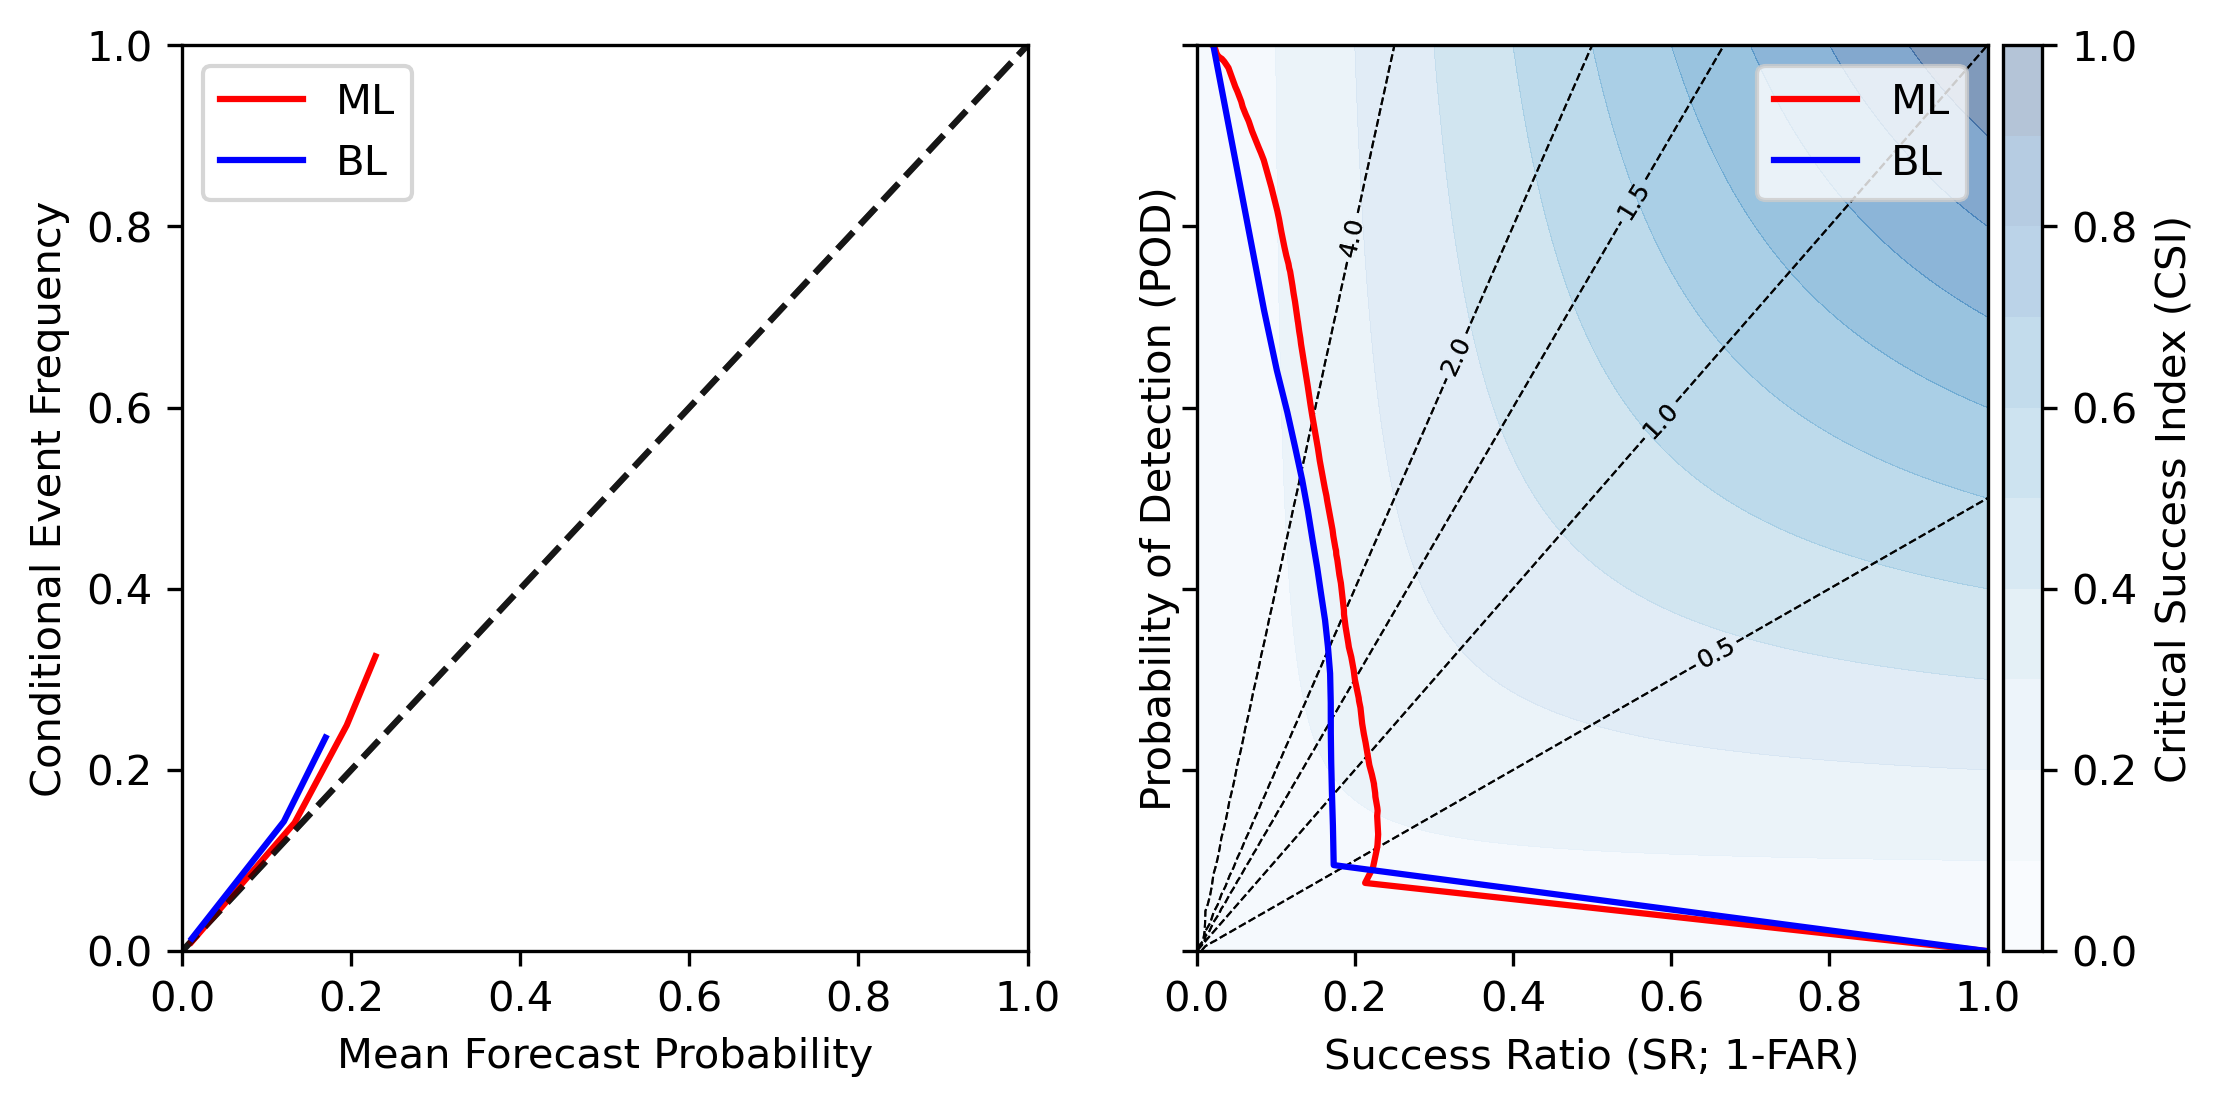

In [9]:
plot_verification(ml_pred, bl_pred)
#plt.savefig(f'{model_name}_{lead_time}_target.png')